<p style="font-family:Times;font-size:250%; text-align:center"> <font color='red'>Recurrent Neural Network (RNN)</font></p>
<p style="font-family:Times;font-size:200%; text-align:center"> <font color='brown'>Untuk data sekuensial</font></p>

# DL2021 - TUGAS 3
## Muhammad Naufal Irham R. (10818019)
Semua code tidak banyak diubah, hanya beberapa bagian tertentu saja yang memang diubah sesuai kebutuhan

In [41]:
from numpy import *   
import numpy as np
from numpy.random import *
import pandas as pd
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sb

##Tambahan library
import torch
import torch.optim as optim

#sb.set_theme()
sb.set_style("whitegrid")
#sb.set_style("darkgrid")

%matplotlib inline

np.set_printoptions(precision = 3, suppress = True, formatter = {'float':'{:6.5f}'.format})

#Sigmoid function & its derivative
sigmoid = lambda Z: 1/(1+torch.exp(-Z))
dsigmoid = lambda A: A*(1-A)

#ReLU function & its derivative
ReLU  = lambda Z: Z.clip(0)
#Derivative of ReLU function
dReLU = lambda A: (A > 0)*1

#Derivativer of tanh()
dtanh = lambda A: 1-A**2

#Derivative oh arctanh
darctanh = lambda A: 1/(A**2+1)

#Softplus function & its derivative
splus = lambda Z: log(1+exp(Z))
dsplus = lambda A: 1/(1+exp(-A))

linear = lambda X,w,b: X@w+b

"Time step (ts)"
def steps(x, step):   
    obs  = len(x)-step
    xt   = x[:obs,:]
    for i in torch.arange(1,step+1):
        xt = torch.hstack((xt, x[i:obs+i,:]))   
    return xt

In [42]:
class RNN:
    def __init__(self,x,nh,alpha,epochs,method = 0): # ada h nodes di dalam hidden layer  hlayers = [7, 3, 34, 89]
        self.Xtrain  = x #input
        self.ytrain  = x[:,-1:] #output     
        self.nh = nh   #number of neurons in hidden layer
        self.α  = alpha
        self.epochs = epochs
        self.Ts = shape(self.Xtrain)[1]-1   # Time-steps
        self.N, no = shape(self.ytrain)     #jumlah observasi (self.N) dan jumlah output
        self.ni    = 1  #jumlah input
        
        ###Modifikasi ada dibawah ini######################################
        self.method = method
        "Initial values untuk parameter w and b"
        self.neurons = [self.ni, self.nh, no]
        
        torch.manual_seed(20201212)
        self.w, self.b = [],[]

        for i in range(len(self.neurons)-1):
            self.w.append(torch.randn(self.neurons[i], self.neurons[i+1], requires_grad = True))
            self.b.append(torch.randn(1, self.neurons[i+1], requires_grad = True))

        self.w.append(torch.randn(self.nh,self.nh, requires_grad = True))
        #####################################################################
    
    def learning(self):
        self.ycap = torch.Tensor([])
        for i in range(len(self.Xtrain)):
            self.S1 = [torch.zeros(self.ni, self.nh)]
            self.S2 = []           
            
            "Forward propagation in time step"
            for k in range(self.Ts):       
                self.A0 = torch.Tensor([self.Xtrain[i,k]])
                yk = torch.Tensor([self.Xtrain[i,k + 1]])
            
                # Forward pass, 1st layer
                Z1 = self.A0@self.w[0] + self.b[0] + (self.S1[-1]@self.w[2]) 
                A1 = torch.tanh(Z1)
                self.S1.append(torch.clone(A1))   
            
                # Forward pass, 2nd layer
                Z2 = A1@self.w[1] + self.b[1]
                A2 = sigmoid(Z2)
                self.S2.append(torch.clone(A2))
            
            self.ycap = torch.cat((self.ycap, A2[0]),0)

            e    = (yk - A2[0])
            self.Cost = e.T@e/self.N  #mean squared error

            "Backward propagation in time step"         
            if self.method == 0: #Backward
                self.Cost.backward()
                for n in range(len(self.neurons)-1):
                    with torch.no_grad():
                        self.w[n] -= self.α*self.w[n].grad   #Parameter w di-update 
                        self.b[n] -= self.α*self.b[n].grad   #Parameter b di-update   
                        # Manually zero the gradients after running the backward pass
                        self.w[n].grad.zero_()
                        self.b[n].grad.zero_()

            elif self.method == 1: #Grad
                for n in range(len(self.neurons)-1):
                    gradw = torch.autograd.grad(self.Cost, self.w[n], retain_graph=True)
                    gradb = torch.autograd.grad(self.Cost, self.b[n], retain_graph=True)
                    with torch.no_grad():
                        self.w[n] -= self.α * gradw[0]
                        self.b[n] -= self.α * gradb[0]

            elif self.method == 2: #Optim
                self.Cost.backward()
                for n in range(len(self.neurons)-1):               
                    optimizer = optim.SGD((self.w[n], self.b[n]), lr = self.α)
                    optimizer.step()
                    optimizer.zero_grad()
        
        #############################################################################

            


#### Contoh #1: Pemakaian RNN untuk memecahkan masalah XOR Gate

In [43]:
X = torch.Tensor([(0,0,0), (1,0,0), (0,1,0), (1,1,1)])   #Input
y = torch.Tensor([0, 1, 1, 0])   #Output

Xtrain = torch.Tensor([[1,1,1,0], 
                [1,0,0,1], 
                [0,1,0,1], 
                [0,0,0,0]])
ytrain = torch.Tensor(y)

In [44]:
nh     = 5
alpha  = 1
epochs = 501

"Training"
### Modifikasi code dimulai dari sini ###################################
method = ["Backward", "Grad", "Optim"]
method_index = 2

print("Metode yang digunakan:", method[method_index])
#########################################################################
tic = datetime.now()

rnn1 = RNN(Xtrain,nh,alpha,epochs,method_index)
tic = datetime.now()

for e in range(epochs):
    rnn1.learning()
    toc = datetime.now()
            
    if e % ((epochs-1)/5) == 0:
        print(f"\nPada epoch ke {e} diperoleh predicted vs actual:")
        print(vstack((rnn1.ycap.detach(), ytrain)).T)

print(f'Waktu untuk training (dengan {epochs} epochs) dan prediksi: ',  datetime.now()-tic)

Metode yang digunakan: Optim

Pada epoch ke 0 diperoleh predicted vs actual:
[[0.31174 0.00000]
 [0.35232 1.00000]
 [0.32324 1.00000]
 [0.58730 0.00000]]

Pada epoch ke 100 diperoleh predicted vs actual:
[[0.04194 0.00000]
 [0.91577 1.00000]
 [0.82065 1.00000]
 [0.18335 0.00000]]

Pada epoch ke 200 diperoleh predicted vs actual:
[[0.02077 0.00000]
 [0.94105 1.00000]
 [0.89537 1.00000]
 [0.11191 0.00000]]

Pada epoch ke 300 diperoleh predicted vs actual:
[[0.01480 0.00000]
 [0.95260 1.00000]
 [0.92043 1.00000]
 [0.08638 0.00000]]

Pada epoch ke 400 diperoleh predicted vs actual:
[[0.01192 0.00000]
 [0.95939 1.00000]
 [0.93362 1.00000]
 [0.07258 0.00000]]

Pada epoch ke 500 diperoleh predicted vs actual:
[[0.01020 0.00000]
 [0.96397 1.00000]
 [0.94199 1.00000]
 [0.06367 0.00000]]
Waktu untuk training (dengan 501 epochs) dan prediksi:  0:00:01.693419


#### Contoh #2: Pemakaian RNN untuk penaksiran harga saham


In [46]:
#device = torch.device('cpu')
device = torch.device('cuda') # Uncomment this to run on CPU

S  = pd.read_csv('INAF.JK.csv')  #Data time series harian harga saham Intel sejak 02 Januari 2015
S6 = S['Adj Close'].values   #Ambil kolom ke enam berisi 'Adj Close', 
B  = S6.reshape(-1,1)  
                                     
Bmin = min(B)
Bmax = max(B)
b = torch.Tensor((B-Bmin)/(Bmax-Bmin))

ts = 1   #Di literatur Time Series digunakan istilah 'lag' sebagai padanan istilah 'timestep' ini
xt = steps(b, ts)  #Dihasilkan matriks dengan 2 (= ts+1) kolom, kolom pertama menjadi variabel X
                   #dan kolom terkhir menjadi variabel y

x = xt[-800:,:]    #Ambil 800 observasi terakhir

#Data untuk training
Xtrain = x[0:680,:]   #Ambil 680 observasi yang pertama dan hilangkan kolom terakhir
ytrain = x[0:680:, -1:]  #Ambil 680 observasi yang pertama dan ambil kolom terakhir sebagai variabel y 

#Data untuk testing
Xtest = x[680:, :]   #ambil jumlah observasi sebanyak 120, hilangkan kolom terakhir (untuk y)
ytest = x[680:, -1:]  #ambil kolom terakhir

#plt.plot(Xtrain, color = 'b')
#plt.show()

Metode yang digunakan: Grad
Epoch ke 0, SSE sebesar: 0.12647 dalam waktu 0:00:00.479186
Epoch ke 7, SSE sebesar: 0.02259 dalam waktu 0:00:03.779288
Epoch ke 14, SSE sebesar: 0.00756 dalam waktu 0:00:07.057251
Epoch ke 21, SSE sebesar: 0.00290 dalam waktu 0:00:10.294712
Epoch ke 28, SSE sebesar: 0.00163 dalam waktu 0:00:13.595086
Epoch ke 35, SSE sebesar: 0.00126 dalam waktu 0:00:16.876551


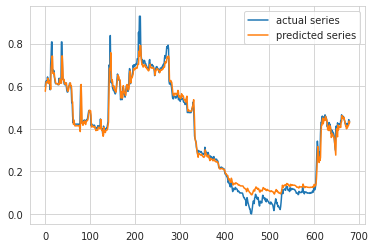

In [47]:
#Ringkasan nh = 3, alpha = 0.27 epochs = 36, ts = 1

nh     = 3
alpha  = 5
epochs = 36

### Modifikasi code dimulai dari sini ###################################
method = ["Backward", "Grad", "Optim"]
method_index = 1

print("Metode yang digunakan:", method[method_index])
#########################################################################

"Training"

rnn2 = RNN(Xtrain,nh,alpha,epochs, method_index)
tic = datetime.now()

for n in range(epochs):
    rnn2.learning()
    e = rnn2.ycap - ytrain[:,0]
    sse = torch.sum(e**2)/len(ytrain[:,0])
    toc = datetime.now()
            
    if n % ((epochs-1)/5) == 0:
        #print(f"\nPada epoch ke {n} diperoleh predicted vs actual:")
        #print(hstack((array(rnn2.ycap), ytrain.reshape(4,1))))
        print(f"Epoch ke {n}, SSE sebesar: {sse.detach().numpy():6.5f} dalam waktu {datetime.now()-tic}")

#rnn = RNN(Xtrain,nh,alpha,epochs)
#rnn.training()

plt.plot(ytrain, label = 'actual series')
plt.plot(rnn2.ycap.detach().numpy(), label = 'predicted series')
plt.legend()
plt.show()

#### Test the model

MSE training: 0.0012608 
MSE testing : 0.0175160


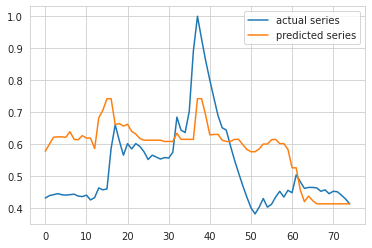

In [48]:
ytestcap = torch.Tensor([])

for i in range(len(Xtest)):
    S1 = [torch.zeros(rnn2.ni, rnn2.nh)]
    S2 = []                    
            
    "Forward propagation in time step"
    for k in range(rnn2.Ts):       
        A0 = torch.Tensor([rnn2.Xtrain[i,k]])
        yk = torch.Tensor([rnn2.Xtrain[i,k + 1]])
            
        # Forward pass, 1st layer
        Z1 = A0@rnn2.w[0] + rnn2.b[0] + (S1[-1]@rnn2.w[2]) 
        A1 = torch.tanh(Z1)
        S1.append(torch.clone(A1))   
            
        # Forward pass, 2nd layer
        Z2 = A1@rnn2.w[1] + rnn2.b[1]
        A2 = sigmoid(Z2)
        S2.append(torch.clone(A2))
            
    ytestcap = torch.cat((ytestcap, A2[0]),0)

e = ytestcap - ytest[:,0]
ssetest = torch.sum(e**2)/len(ytest[:,0])
print('MSE training: %8.7f'%sse.detach().numpy(),'\nMSE testing : %7.7f'%ssetest.detach().numpy())
      
plt.plot(ytest, label = 'actual series')
plt.plot(ytestcap.detach().numpy(), label = 'predicted series')
plt.legend()
plt.show()